# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Code Test
27/06/2020

# 0. Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import scipy.stats
from pandas.plotting import register_matplotlib_converters

from sklearn import linear_model
from statsmodels.tsa._stl import STL
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.graphics import tsaplots
from fbprophet import Prophet
import ephem

In [4]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [6]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [7]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

In [8]:
def progressBar(value, endvalue, bar_length=20):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write(
        "\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [9]:
def prophet_predict_by_chunks(df_to_forecast, model):
    """ 
    Prophet seems to struggle with big chunks of data. 
    Let's break it into smaller pieces.
    """
    index_df = pd.DatetimeIndex(df_to_forecast['ds'])
    forecast = pd.DataFrame()
    total_chunks = 0
    for i, year in enumerate(list(index_df.year.unique())):
        for j, month in enumerate(list(index_df[index_df.year==year].month.unique())):
            total_chunks += 1
    
    iteration = 0
    for year in list(index_df.year.unique()):
        for month in list(index_df[index_df.year==year].month.unique()):
            df_ij = df_to_forecast.loc[((index_df.year == year)&(index_df.month == month))]
            forecast = forecast.append(model.predict(df_ij))
            
            iteration += 1
            progressBar(iteration, total_chunks, bar_length=20)
    
    return forecast

# 1. Import data
### 1.1 Load data

In [10]:
main_df = pd.read_csv('Data/venezia_transformed.csv')

display(main_df.head())
main_df.info()

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Z_score(level)
0,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.621921
1,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.312961
2,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,-0.098986
3,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,-0.545262
4,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,-0.854222


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289277 entries, 0 to 289276
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          289277 non-null  object 
 1   level             289277 non-null  float64
 2   moon_dist         289277 non-null  float64
 3   sun_dist          289277 non-null  float64
 4   moon_phase        289277 non-null  float64
 5   sun_acceleration  289277 non-null  float64
 6   Z_score(level)    289277 non-null  float64
dtypes: float64(6), object(1)
memory usage: 15.4+ MB


In [11]:
date_column = 'datetime'
forecast_column = 'level'

features = sorted(set(main_df.columns) - set([date_column, forecast_column]))

### 2.1 First data checks

In [12]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m-%d %H', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column] + features:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Z_score(level)
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.621921
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.312961
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,-0.098986
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,-0.545262
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,-0.854222


,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Z_score(level)
2015-12-31 20:00:00,2015-12-31 20:00:00,-18.0,0.002690,0.983315,0.829786,6.124559e-23,-1.506471
2015-12-31 21:00:00,2015-12-31 21:00:00,-14.0,0.002691,0.983315,0.827312,6.124565e-23,-1.369155
2015-12-31 22:00:00,2015-12-31 22:00:00,-5.0,0.002692,0.983315,0.824822,6.124570e-23,-1.060195
2015-12-31 23:00:00,2015-12-31 23:00:00,8.0,0.002692,0.983314,0.822316,6.124575e-23,-0.613919
2016-01-01 00:00:00,2016-01-01 00:00:00,20.0,0.002693,0.983314,0.819793,6.124581e-23,-0.201972


In [13]:
# Frequency seems hourly. Let´s double check
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('hours elapsed: ' + str((main_df.index.max() - main_df.index.min())/pd.Timedelta(hours=1) + 1))

dataframe rows: 289272
hours elapsed: 289272.0


# 2. Modelling exploratory

## 2.0 Train-test split

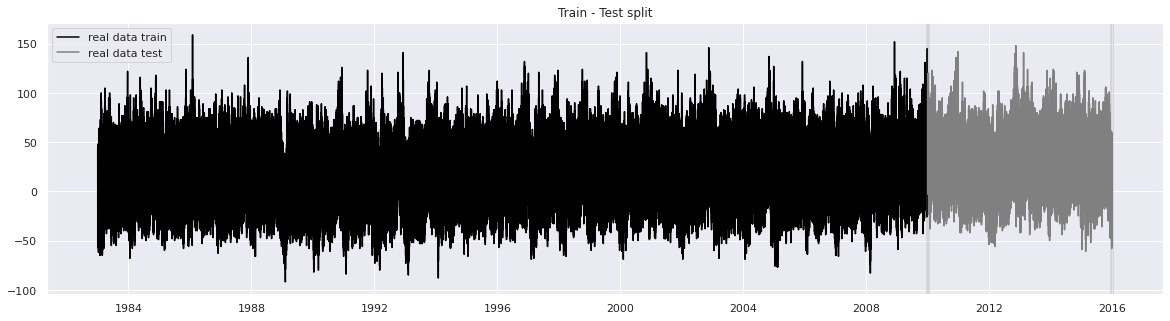

In [14]:
separating_date_1 = pd.to_datetime('20100101', format='%Y%m%d')
separating_date_2 = pd.to_datetime('20201201', format='%Y%m%d')
train_df = main_df.loc[main_df.index < separating_date_1]
test_df = main_df.loc[((main_df.index >= separating_date_1)&(main_df.index < separating_date_2))]


# Visualise train test split
plt.title('Train - Test split')
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

# 2.1 Prophet - solar seasonality

In [30]:
features = ['sun_acceleration']
train_prophet = train_df[[forecast_column]+features].reset_index()
train_prophet.columns = ['ds','y']+features
test_prophet = test_df[[forecast_column]+features].reset_index()
test_prophet.columns = ['ds','y']+features

# Prophet https://facebook.github.io/prophet/docs/
m_3_1 = Prophet(seasonality_mode='multiplicative', #seasonality_mode='multiplicative' or 'additive'
              interval_width=0.95, 
              daily_seasonality = False, 
              weekly_seasonality = False, 
              yearly_seasonality = False,
            #growth='logistic')
           )

# https://stackoverflow.com/questions/47534553/how-to-extract-seasonal-trends-from-prophet
m_3_1.add_seasonality(name='S2_solar_principal_semidiurnal', period=(12/24), fourier_order=2)
m_3_1.add_seasonality(name='K2_lunisolar_semidiurnal', period=(11.96723606/24), fourier_order=2)
m_3_1.add_seasonality(name='P1_solar_diurnal', period=(24.06588766/24), fourier_order=2)
m_3_1.add_regressor('sun_acceleration')

m_3_1.fit(train_prophet)

In [36]:
# Predict over train data
"""
forecast_train = prophet_predict_by_chunks(train_prophet, m_3_1)
forecast_train.to_csv('Data/Venezia/m3_1_forecast_train.csv')
"""
forecast_train = pd.read_csv('Data/Venezia/m3_1_forecast_train.csv').drop('Unnamed: 0', axis=1)
forecast_train['ds'] = pd.to_datetime(forecast_train['ds'], errors='coerce')
forecast_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,K2_lunisolar_semidiurnal,K2_lunisolar_semidiurnal_lower,K2_lunisolar_semidiurnal_upper,P1_solar_diurnal,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sun_acceleration,sun_acceleration_lower,sun_acceleration_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1983-01-01 01:00:00,18.507471,-26.562448,77.038608,18.507471,18.507471,0.007031,0.007031,0.007031,0.035669,...,0.278342,0.278342,0.278342,0.007030,0.007030,0.007030,0.0,0.0,0.0,23.658873
1,1983-01-01 02:00:00,18.507929,-29.655196,76.834325,18.507929,18.507929,0.097350,0.097350,0.097350,0.093089,...,0.129447,0.129447,0.129447,0.007030,0.007030,0.007030,0.0,0.0,0.0,20.903733
2,1983-01-01 03:00:00,18.508387,-32.999268,70.844051,18.508387,18.508387,0.162291,0.162291,0.162291,0.144141,...,-0.037220,-0.037220,-0.037220,0.007031,0.007031,0.007031,0.0,0.0,0.0,17.819504
3,1983-01-01 04:00:00,18.508846,-35.453025,71.084056,18.508846,18.508846,0.184430,0.184430,0.184430,0.185522,...,-0.164683,-0.164683,-0.164683,0.007031,0.007031,0.007031,0.0,0.0,0.0,15.460747
4,1983-01-01 05:00:00,18.509304,-40.149562,65.314616,18.509304,18.509304,0.156953,0.156953,0.156953,0.214560,...,-0.207003,-0.207003,-0.207003,0.007031,0.007031,0.007031,0.0,0.0,0.0,14.677818


In [37]:
# Predict over validation data 
"""
forecast_test = prophet_predict_by_chunks(test_prophet, m_3_1)
forecast_test.to_csv('Data/Venezia/m3_1_forecast_test.csv')
"""
forecast_test = pd.read_csv('Data/Venezia/m3_1_forecast_test.csv').drop('Unnamed: 0', axis=1)
forecast_test['ds'] = pd.to_datetime(forecast_test['ds'], errors='coerce')
forecast_test.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,K2_lunisolar_semidiurnal,K2_lunisolar_semidiurnal_lower,K2_lunisolar_semidiurnal_upper,P1_solar_diurnal,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sun_acceleration,sun_acceleration_lower,sun_acceleration_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-01 00:00:00,30.134493,-11.072978,93.836604,30.134493,30.134493,-0.084815,-0.084815,-0.084815,-0.024678,...,0.359549,0.359549,0.359549,0.007017,0.007017,0.007017,0.0,0.0,0.0,40.969319
1,2010-01-01 01:00:00,30.134601,-13.642601,93.370923,30.134601,30.134601,0.007527,0.007527,0.007527,0.035364,...,0.278520,0.278520,0.278520,0.007017,0.007017,0.007017,0.0,0.0,0.0,38.527697
2,2010-01-01 02:00:00,30.134709,-20.527551,86.377762,30.134709,30.134709,0.097773,0.097773,0.097773,0.092808,...,0.129575,0.129575,0.129575,0.007017,0.007017,0.007017,0.0,0.0,0.0,34.039410
3,2010-01-01 03:00:00,30.134818,-25.831770,83.372993,30.134818,30.134818,0.162529,0.162529,0.162529,0.143900,...,-0.037236,-0.037236,-0.037236,0.007017,0.007017,0.007017,0.0,0.0,0.0,29.012714
4,2010-01-01 04:00:00,30.134926,-25.435483,80.937050,30.134926,30.134926,0.184416,0.184416,0.184416,0.185339,...,-0.164894,-0.164894,-0.164894,0.007018,0.007018,0.007018,0.0,0.0,0.0,25.165866


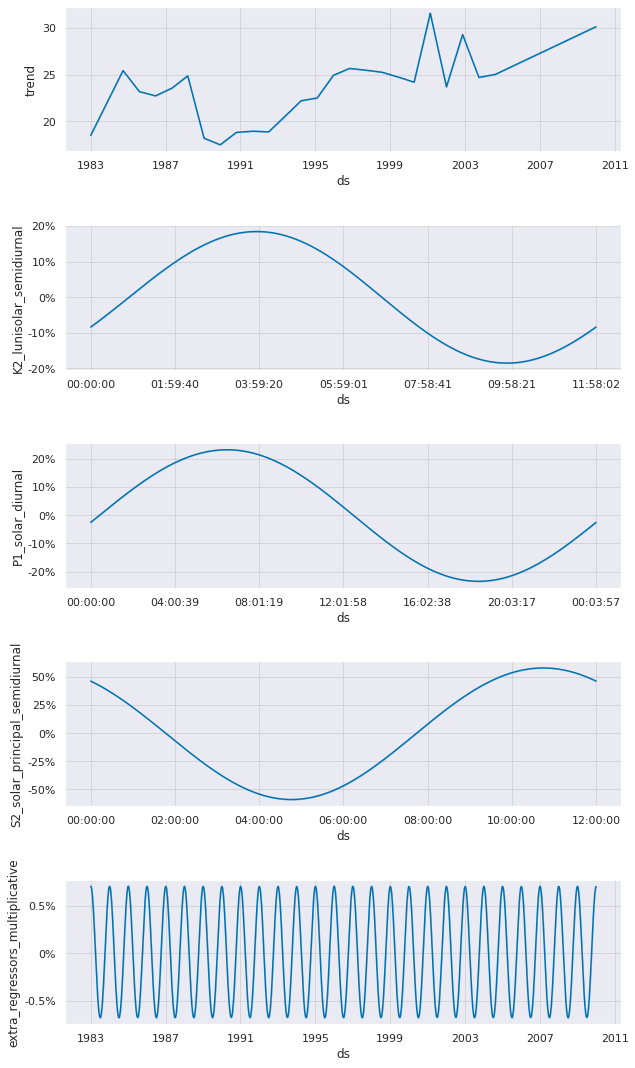

In [38]:
# Plot Prophet components
fig = m_3_1.plot_components(forecast_train)
plt.show()

In [39]:
y_train_pred = forecast_train[['ds','yhat']].set_index('ds',drop=True)
y_train_pred.index.name = None
y_train_pred = y_train_pred['yhat']

y_test_pred = forecast_test[['ds','yhat']].set_index('ds',drop=True)
y_test_pred.index.name = None
y_test_pred = y_test_pred['yhat']

y_all_pred = y_train_pred.append(y_test_pred)

/home/alumno/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



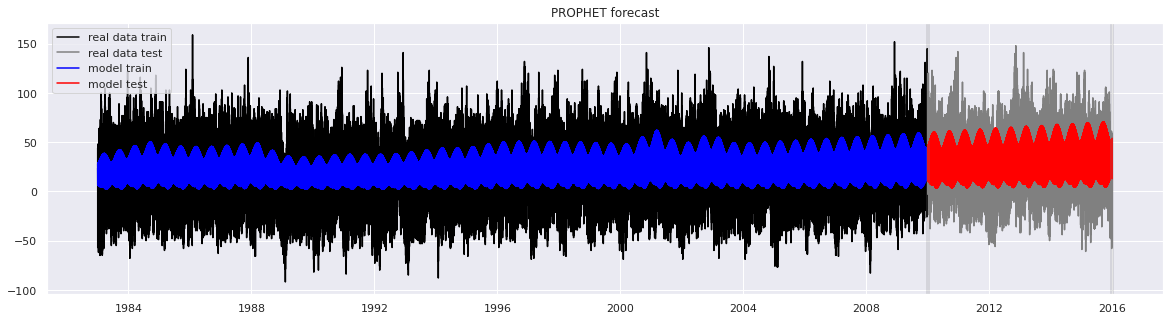

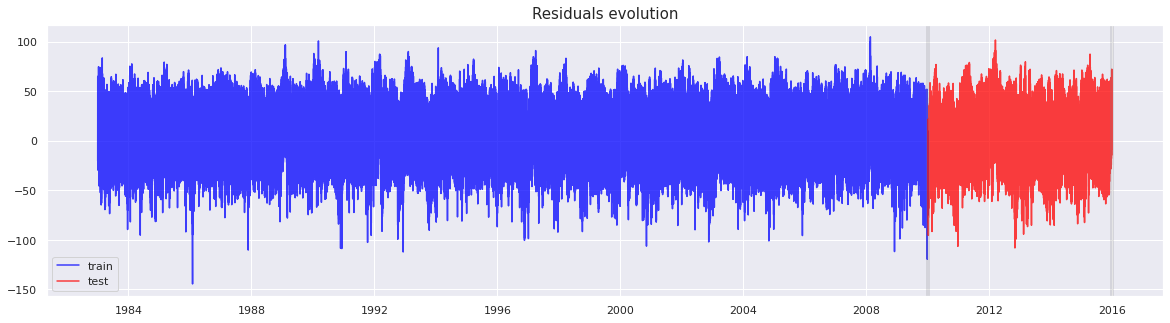

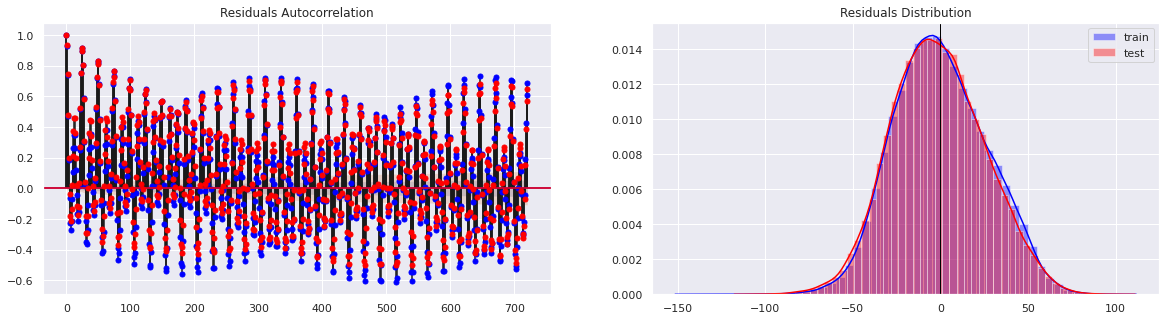

In [43]:
# PLOT

# Visualise forecast
plt.title('PROPHET forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24*30)

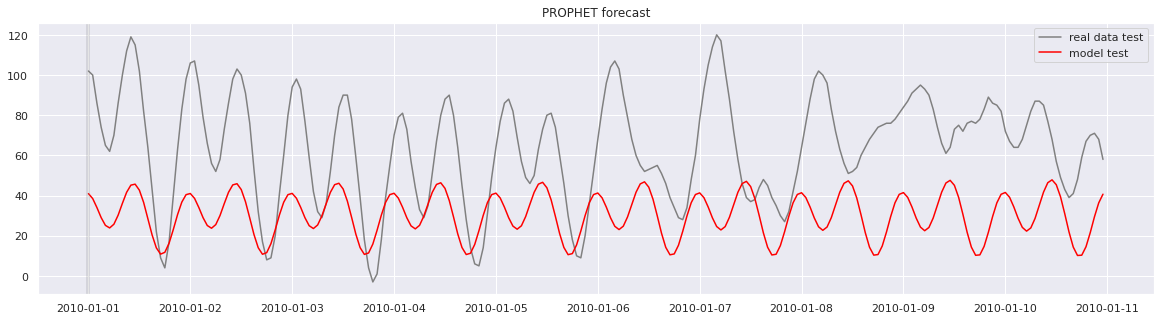

In [41]:
# Zoom in
plt.title('PROPHET forecast')
data_points_to_check = 24*10
# Real data
plt.plot(test_df.index[:data_points_to_check], test_df[forecast_column][:data_points_to_check], color='grey', label='real data test')
# Model
plt.plot(y_test_pred.index[:data_points_to_check], y_test_pred[:data_points_to_check], color='red', label='model test')
# Test reference lines
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

In [42]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.median(np.abs((train_df[forecast_column] - y_train_pred) / train_df[forecast_column])), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.median(np.abs((test_df[forecast_column] - y_test_pred) / test_df[forecast_column])), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

,Metrics,Train,Test,Degradation (%)
0,MAPE,0.577351,0.485364,-15.93
1,MSE,26.414347,26.513552,0.38
2,R2,0.171880,0.107778,-37.29
